<a href="https://colab.research.google.com/github/maschere/public-jupyter/blob/master/genGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Genetic algorithm steered by mobilenet to generate images by painting circles 

In [ ]:
# clone bob ross image repo
!git clone https://github.com/jwilber/Bob_Ross_Paintings.git
import pathlib
all_images = list(pathlib.Path("Bob_Ross_Paintings/data/paintings").glob('*.png'))

Cloning into 'Bob_Ross_Paintings'...
remote: Enumerating objects: 473, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 473 (delta 0), reused 0 (delta 0), pack-reused 465
Receiving objects: 100% (473/473), 79.24 MiB | 32.10 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [ ]:
# generative Genetic algorithm
# %%
from typing import Callable

from IPython.display import display
import numpy as np
from PIL import Image
from skimage import draw
import random


class indi:
    """individium class"""

    def __init__(self, func: Callable):
        """init individum with random starting image

        Args:
            func (Callable): fitness funciton taking an image as parameter
        """
        #self.img = np.asarray(Image.open(str(random.choice(all_images))).resize((256,256)), dtype=np.float32)/255.0
        self.img = np.zeros((256,256,3))
        self.fitness = func

    def eval(self) -> float:
        return self.fitness(self.img)

    def mutate(self, sigma=0.1):
        """mutate by drawing randomly colored circles in the image"""
        color = (np.random.randn(3)+0.1)*sigma
        circle = np.zeros((256,256,3))
        rr, cc = draw.circle(np.random.randint(255), np.random.randint(255), radius=8+int(32*np.random.uniform()), shape=(256,256))
        circle[rr,cc,:] = 1
        circle *= color
        self.img += circle

#https://stackoverflow.com/questions/42147776/producing-2d-perlin-noise-with-numpy
def perlin(x,y,seed=None):
    # permutation table
    if seed is not None:
      np.random.seed(seed)
    p = np.arange(256,dtype=int)
    np.random.shuffle(p)
    p = np.stack([p,p]).flatten()
    # coordinates of the top-left
    xi = x.astype(int)
    yi = y.astype(int)
    # internal coordinates
    xf = x - xi
    yf = y - yi
    # fade factors
    u = fade(xf)
    v = fade(yf)
    # noise components
    n00 = gradient(p[p[xi]+yi],xf,yf)
    n01 = gradient(p[p[xi]+yi+1],xf,yf-1)
    n11 = gradient(p[p[xi+1]+yi+1],xf-1,yf-1)
    n10 = gradient(p[p[xi+1]+yi],xf-1,yf)
    # combine noises
    x1 = lerp(n00,n10,u)
    x2 = lerp(n01,n11,u) # FIX1: I was using n10 instead of n01
    return lerp(x1,x2,v) # FIX2: I also had to reverse x1 and x2 here

def lerp(a,b,x):
    "linear interpolation"
    return a + x * (b-a)

def fade(t):
    "6t^5 - 15t^4 + 10t^3"
    return 6 * t**5 - 15 * t**4 + 10 * t**3

def gradient(h,x,y):
    "grad converts h to the right gradient vector and return the dot product with (x,y)"
    vectors = np.array([[0,1],[0,-1],[1,0],[-1,0]])
    g = vectors[h%4]
    return g[:,:,0] * x + g[:,:,1] * y


def xover(a: indi, b: indi) -> indi:
    """crossover between two individuals by randomly-weighted interpolation
    """
    c = indi(a.fitness)
    lin = np.linspace(0,5,256,endpoint=False)
    x,y = np.meshgrid(lin,lin)
    rel = perlin(x,y)
    rel = rel - rel.min()
    rel = rel / rel.max()
    rel = np.stack((rel,rel,rel),axis=2)
    c.img = rel * a.img + (1 - rel) * b.img
    return c




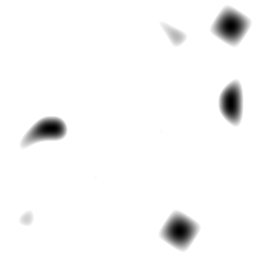

In [ ]:
lin = np.linspace(0,5,256,endpoint=False)
x,y = np.meshgrid(lin,lin)
rel = perlin(x,y)
rel = rel - rel.min()
rel = rel / rel.max()
rel *= 5
rel = np.stack((rel,rel,rel),axis=2)
Image.fromarray((np.clip((rel),0,1)*255).astype(np.uint8))

In [ ]:
# imagenet steering
import torch
from torchvision import transforms

model = torch.hub.load('pytorch/vision:v0.9.0', 'mobilenet_v2', pretrained=True).cuda()
model.eval()
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


def tensor_to_img(x):
    return Image.fromarray((np.clip([0.485, 0.456, 0.406] + x.permute([1,2,0]).numpy()*[0.229, 0.224, 0.225],0,1)*255).astype(np.uint8))

def array_to_img(x):
    return Image.fromarray((np.clip((x),0,1)*255).astype(np.uint8))

#target_class =  71# 'scorpion',
target_class =  288 # leoparrd

def fitness(img):
    with torch.no_grad():
        probs = model.forward(preprocess(array_to_img(img)).unsqueeze(0).cuda())
        return probs.max().detach().cpu().numpy() #maximize any one class in imagenet



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


In [ ]:
#%% run it
popsize = 200
maxgen = 10000
use_elitism = False
allow_self_reproduction = False
pop = [indi(fitness) for i in range(popsize)]
!mkdir imgs

mkdir: cannot create directory ‘imgs’: File exists


In [ ]:
# %%
for gen in range(maxgen):
    if gen > 0:
      pop.sort(key=lambda p0: p0.eval(), reverse=True)
    best = pop[0]
    print(f"{gen}: fitness: {best.eval()}")
    array_to_img(best.img).save(f"imgs/bestimg{gen}.png")

    # cross over top 10 indis of old pop
    pop = pop[0:10]
    new_pop = []
    for a in pop:
        for b in pop:
            if allow_self_reproduction == False and a == b:
                continue
            new_ind = xover(a, b)
            new_ind.mutate()
            new_ind.mutate()
            new_ind.mutate()
            new_pop.append(new_ind)
    if use_elitism:
        pop = pop[0:1] + new_pop
    else:
        pop = new_pop

# %%


0: fitness: 3.8146049976348877
1: fitness: 10.767754554748535
2: fitness: 12.683655738830566
3: fitness: 13.859115600585938
4: fitness: 13.54750919342041
5: fitness: 13.129260063171387


KeyboardInterrupt: ignored

In [ ]:
!ffmpeg -r 20 -i /content/imgs/bestimg%d.png -vcodec mpeg4 -y movie.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib